In [1]:
""" 
MIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb

The features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., one ICD code)
"""

' \nMIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb\n\nThe features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., one ICD code)\n'

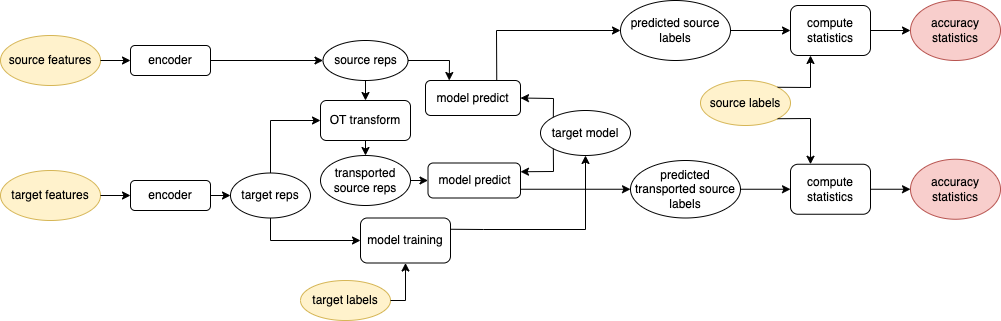

In [2]:
from IPython.display import Image
Image(filename='../../outputs/pipeline_figs/EHR_MIMIC_pipeline.png')

In [3]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from common import *
from mimic_common import *
from ast import literal_eval
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [4]:
def select_df(df, label_code, male_count, female_count):
    """ 
    Select row in the dataframe df with balanced number of labels for males and females
    Specifically, we want to reduce the number of rows with label 0 for males and females

    :param Dataframe df: the dataframe to select samples with label 0 and label 1
    :param str label_code: the ICD code for determining labels. This code should be removed from ICD codes.
    :param int target_count: the number of samples with label 1s and label 0s for target (male). 
    :param int source_count: the number of samples with label 1s and label 0s for source (female). 
    """

    # select samples based on counts
    female_1_indices = []
    female_0_indices = []
    male_1_indices = []
    male_0_indices = []

    # generate label column based on label_code
    if 'label' in df.columns:
        df = df.drop(['label'], axis=1)
    labels = []
    for index, row in df.iterrows():
        if label_code in row['ICD codes']:
            labels.append(1)
        else:
            labels.append(0)
    df['label'] = labels

    for index, row in df.iterrows():
        if row['label'] == 0 and row['gender'] == 'F':
            female_0_indices.append(index)
        elif row['label'] == 0 and row['gender'] == 'M':
            male_0_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'F':
            female_1_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'M':
            male_1_indices.append(index)
    
    # indices to delete from the dataframe
    # sample the same number of label 0s and label 1s
    delete_female_0_indices = random.sample(female_0_indices, len(female_0_indices)-female_count)
    delete_male_0_indices = random.sample(male_0_indices, len(male_0_indices)-male_count)
    delete_female_1_indices = random.sample(female_1_indices, len(female_1_indices)-female_count)
    delete_male_1_indices = random.sample(male_1_indices, len(male_1_indices)-male_count)

    delete_female_0_indices.extend(delete_male_0_indices)
    delete_female_0_indices.extend(delete_female_1_indices)
    delete_female_0_indices.extend(delete_male_1_indices)
    
    df = df.drop(delete_female_0_indices, axis=0, inplace=False)

    # remove label_code from ICD code features
    for index, row in df.iterrows():
        if label_code in row['ICD codes']:
            new_codes = row['ICD codes']
            new_codes.remove(label_code)
            df.at[index, 'ICD codes'] = new_codes
    
    return df


         adm_type gender                                          ICD codes  \
admid                                                                         
172335  EMERGENCY      F  [40301, 486, 58281, 5855, 4254, 2762, 7100, 27...   
173633  EMERGENCY      F  [40301, 5856, 58381, 7100, 5589, 2875, 28521, ...   
174105  EMERGENCY      M                   [53100, 41071, 2859, 41401, 725]   
109976  EMERGENCY      M                                [1915, 3314, 53081]   
178393   ELECTIVE      M             [41401, 4111, 48283, 2859, 2720, 3051]   
...           ...    ...                                                ...   
172304   ELECTIVE      F             [20280, 3485, 7843, 4019, 2720, 53081]   
152542  EMERGENCY      M  [566, 25062, 3572, V5867, 42731, 4019, 4280, 5...   
161999  EMERGENCY      M  [43411, 3485, 3484, 430, 34830, 99731, 51883, ...   
189314  EMERGENCY      F  [34680, 7843, 7455, 78194, 36840, 7813, 7820, ...   
168949  EMERGENCY      M  [0529, 4162, 20192, 135, 2

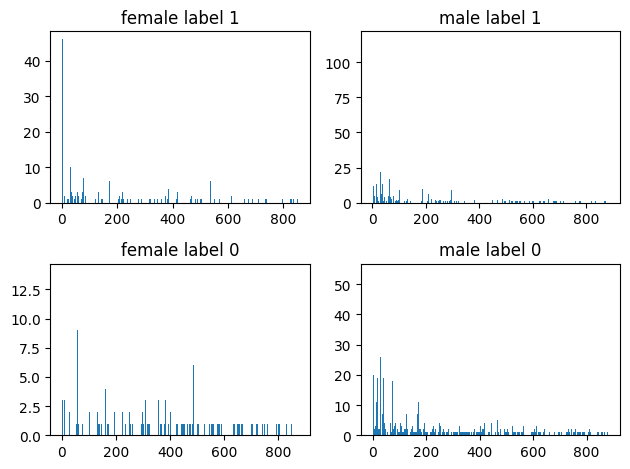

In [9]:
""" 
Read in the original dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
print(admid_diagnosis_df)

""" 
Print number of patients for each category
"""
print("female label 0", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 0) & (admid_diagnosis_df['gender'] == 'F')].shape[0])
print("female label 1", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 1) & (admid_diagnosis_df['gender'] == 'F')].shape[0])
print("male label 0", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 0) & (admid_diagnosis_df['gender'] == 'M')].shape[0])
print("male label 1", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 1) & (admid_diagnosis_df['gender'] == 'M')].shape[0])

""" 
Select subset of the original dataframe
"""
male_count = 120
female_count = 50
label_code = "4111"
admid_diagnosis_select_df = select_df(admid_diagnosis_df, label_code, male_count=male_count, female_count=female_count)


""" 
Print number of patients for each category
"""
print("female label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("female label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("male label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])
print("male label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])

""" 
Dataframe after selection
"""

print(admid_diagnosis_select_df)

""" 
Plot code distribution
"""
plot_code_distn(admid_diagnosis_select_df)

In [11]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var)
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var)

    return target_reps, source_reps

In [14]:
""" 
One iteration
"""

n_components = 50
entire_proc(n_components, label_code, admid_diagnosis_df, custom_train_reps, male_count, female_count, pca_explain=True)

Cummulative variance explained by the source PCA is: [0.06201553 0.11114074 0.14961423 0.1852632  0.21722106 0.2464531
 0.27442819 0.30033101 0.32588732 0.34880289 0.37147992 0.3930616
 0.41392472 0.43418821 0.45374147 0.47221866 0.49029047 0.50764279
 0.52430056 0.54054546 0.55635036 0.57151718 0.58563626 0.59921984
 0.61263973 0.62537723 0.63757469 0.64965655 0.66133035 0.67274235
 0.68365953 0.69413849 0.70436234 0.71427398 0.72412613 0.73378223
 0.74334608 0.75251137 0.76146093 0.77034567 0.77883716 0.78726157
 0.7952022  0.80302114 0.81050974 0.81797095 0.82515133 0.83211988
 0.83891115 0.84562904]
Cummulative variance explained by the target PCA is: [0.05691369 0.09452594 0.12818966 0.15821483 0.18275809 0.20639585
 0.22861443 0.24765653 0.26549396 0.28234375 0.29842905 0.31434893
 0.32988714 0.34427252 0.35796241 0.37158369 0.38435832 0.39673431
 0.40849876 0.42014386 0.43163013 0.44286793 0.45380527 0.46436081
 0.474687   0.48465996 0.49450147 0.50392374 0.51328356 0.5224434
 0

(0.9291666666666667,
 0.9328063241106719,
 0.2,
 0.11111111111111112,
 0.23,
 0.2524271844660194)

In [17]:
""" 
Run the entire procedure multiple times
"""

score_path = "../../outputs/mimic/exp_2_score.csv"
res = multi_proc(score_path, n_components, label_code, admid_diagnosis_df, custom_train_reps, \
                 male_count, female_count, iteration=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75
iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99


number of stats is: 100
number of 0 in incre is: 3
number of elements > 0 is: 61
number of elements < 0 is: 36
average trans source to source accuracy increment is: 0.021700000000000004
median trans source to source accuracy increment is: 0.020000000000000018
average trans source to source accuracy f1 is: 0.045759969051574645
median trans source to source accuracy f1 is: 0.04082482232456114
average trans source to source accuracy is: 1.105850487064255
median trans source to source accuracy is: 1.0397368421052633
average trans source to source f1 is: 1.2648272919004688
median trans source to source f1 is: 1.0754113520408164


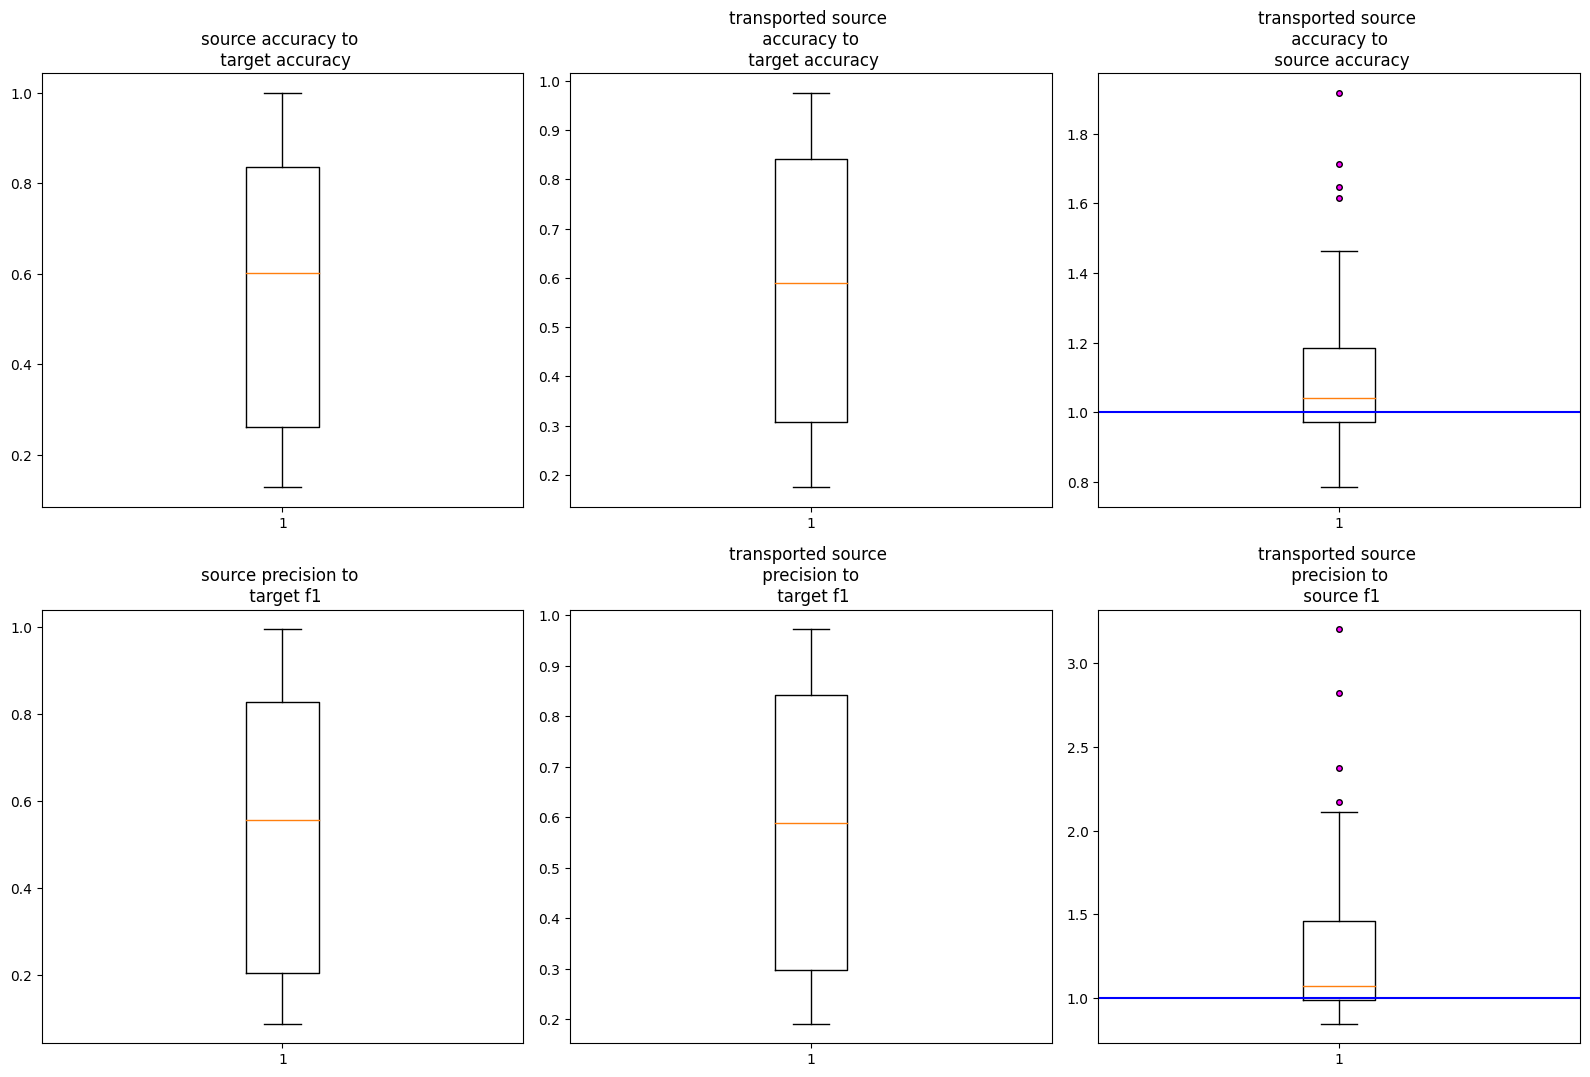

In [18]:
box_plot(score_path, filter=False)

average trans source to source accuracy increment is 2.2%
median trans source to source accuracy increment is 2.0%
average trans source to source accuracy f1 is 4.6%
median trans source to source accuracy f1 is 4.1%


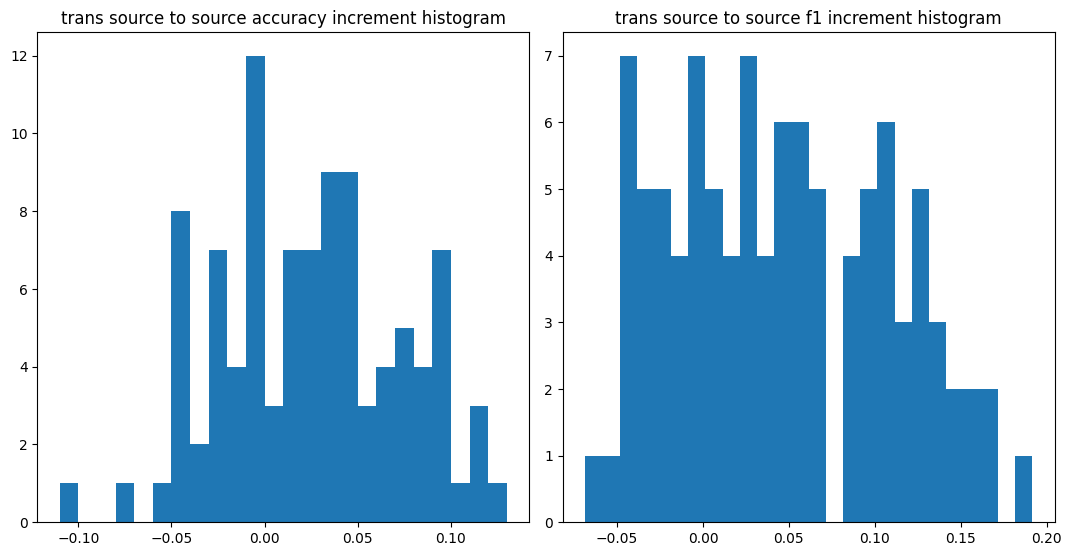

In [19]:
hist_plot(score_path, filter=False)